In [1]:
import pandas as pd
import numpy as np

# Part 1: Data Preparation and Exploration

In [2]:
data=pd.read_csv("exchange_rate.csv")

In [3]:
data.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
#as the data is in date format lets parse the data first

In [5]:
# Load the dataset
data = pd.read_csv('exchange_rate.csv', parse_dates=['date'], dayfirst=True)

In [6]:
# Set the date as the index
data.set_index('date', inplace=True)
data.sort_index(inplace=True)

print(data.head())


            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849


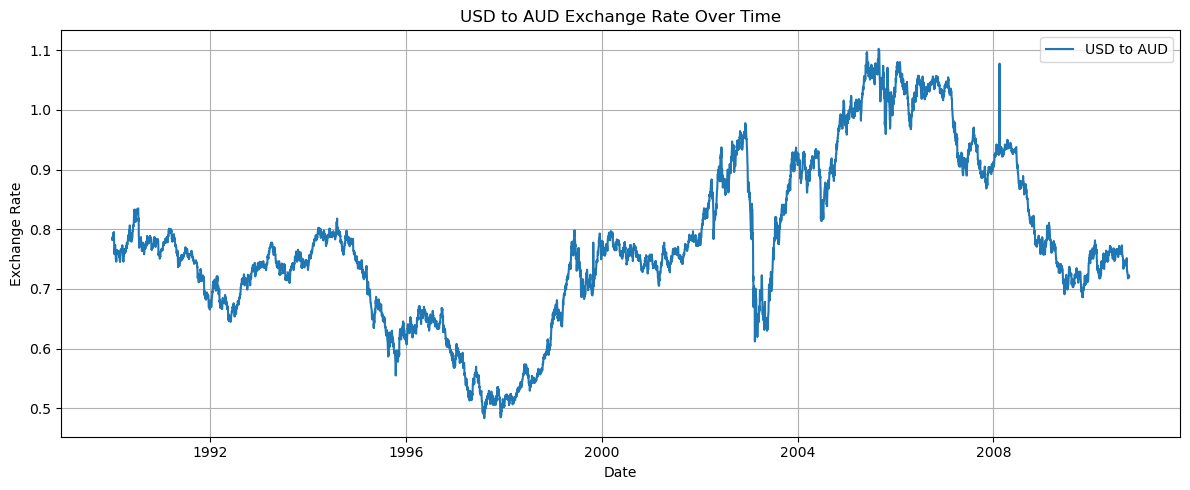

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(data['Ex_rate'], label='USD to AUD')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
data.isnull().sum()

Ex_rate    0
dtype: int64

In [9]:
#there are no missing values

# Part 2: Model Building - ARIMA

In [10]:
#first lets check the datas stationarity using adf test

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Ex_rate'])
print('adf Statistic:', result[0])
print('p_value:', result[1])

adf Statistic: -1.6649941807380766
p_value: 0.44923273535982966


In [12]:
#the p_value>0.05 which shows the data is not stationary

In [13]:
data_diff = data['Ex_rate'].diff().dropna()

In [14]:
result = adfuller(data_diff)
print('ADF Statistic (after differencing):', result[0])
print('p-value:', result[1])

ADF Statistic (after differencing): -99.39343120118626
p-value: 0.0


In [15]:
#now the data is stationary

/Users/nikhil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


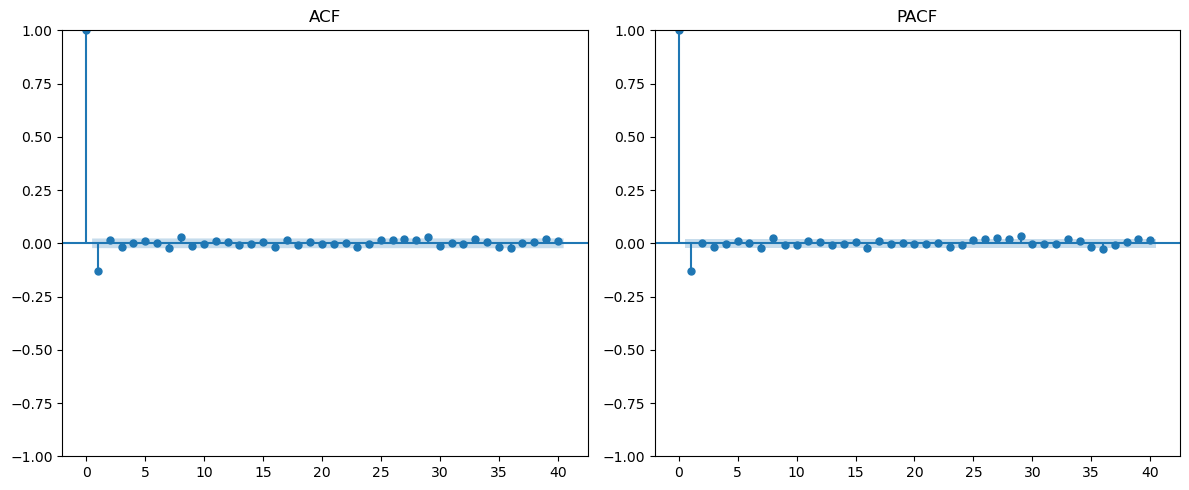

In [16]:
#plotting the acf and pacf plots to select the p,q and d for the arima model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(data_diff, ax=plt.gca(), lags=40)
plt.title('ACF')

plt.subplot(122)
plot_pacf(data_diff, ax=plt.gca(), lags=40)
plt.title('PACF')

plt.tight_layout()
plt.show()


In [17]:
#we are using arima ,odel [000] based on acf and pacf plots

In [18]:
from statsmodels.tsa.arima.model import ARIMA

#ARIMA model
model = ARIMA(data['Ex_rate'], order=(0, 0, 0))
model_fit = model.fit()

#Summary
print(model_fit.summary())


/Users/nikhil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/nikhil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/nikhil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                          ARIMA   Log Likelihood                4337.879
Date:                Fri, 18 Apr 2025   AIC                          -8671.758
Time:                        12:07:20   BIC                          -8657.890
Sample:                    01-01-1990   HQIC                         -8666.999
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7770      0.002    485.265      0.000       0.774       0.780
sigma2         0.0187      0.000     55.195      0.000       0.018       0.019
Ljung-Box (L1) (Q):                7575.95   Jarque-

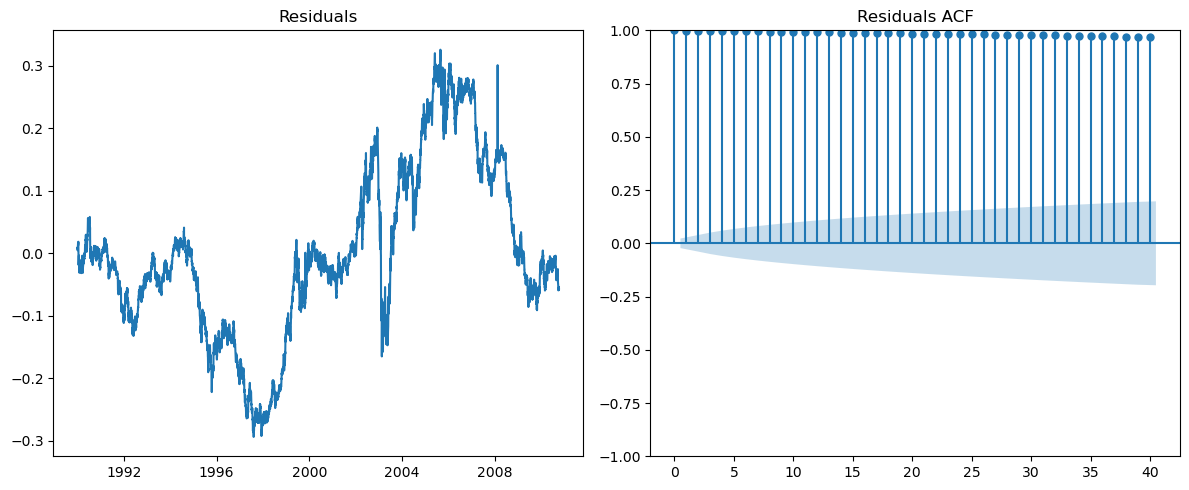

In [19]:
#diagnostics
residuals = model_fit.resid

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(residuals)
plt.title('Residuals')

plt.subplot(122)
plot_acf(residuals.dropna(), ax=plt.gca(), lags=40)
plt.title('Residuals ACF')

plt.tight_layout()
plt.show()

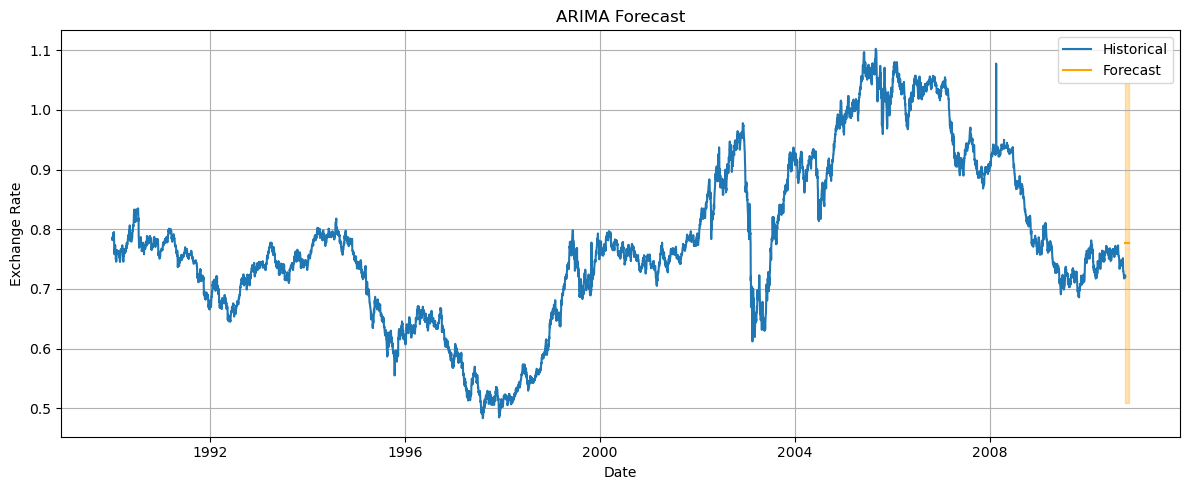

In [20]:
#forecasting
forecast = model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(data.index[-1], periods=30, freq='D')

#Extracting forecast and confidence intervals
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12, 5))
plt.plot(data['Ex_rate'], label='Historical')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange')
plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='orange', alpha=0.3)
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Part 3: Model Building - Exponential Smoothing

In [21]:
#model selection

#here we are using holt winters as its best suitale for both trend and seasonality

In [22]:
#parameter optimization
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

#Fitting Holt-Winters model with multiplicative seasonal components
model_hw = ExponentialSmoothing(data['Ex_rate'],trend='add',seasonal='add',seasonal_periods=12)  # Assuming monthly seasonality (change as needed)

#Fitting the model
model_hw_fit = model_hw.fit()

#summary
print(model_hw_fit.summary())


/Users/nikhil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77624.574
Trend:                         Additive   BIC                         -77513.625
Seasonal:                      Additive   AICC                        -77624.483
Seasonal Periods:                    12   Date:                 Fri, 18 Apr 2025
Box-Cox:                          False   Time:                         12:07:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8702068                alpha                 True
smoothing_trend          

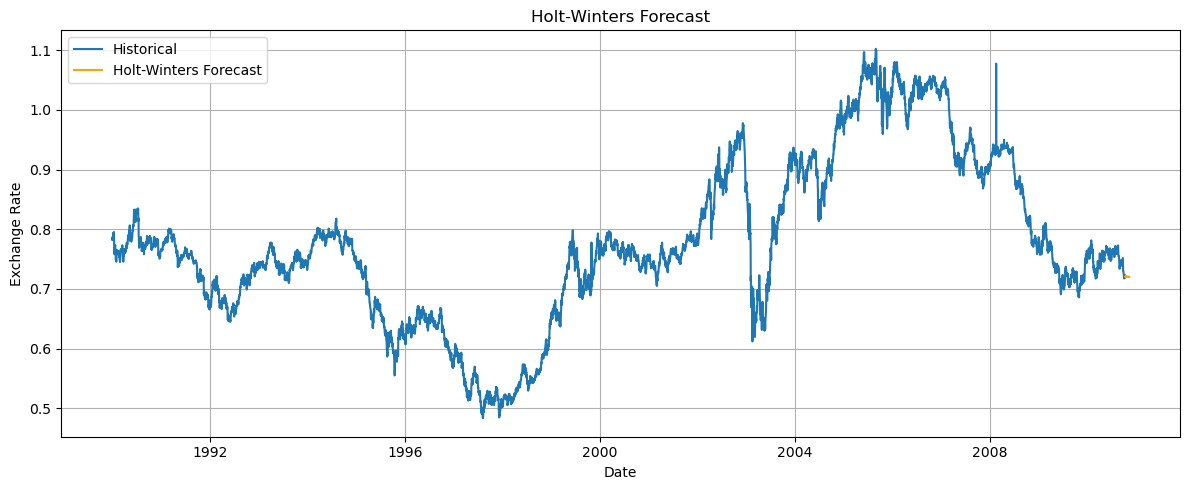

In [23]:
#model fiiting with holt winters
# Forecast next 30 days
forecast_hw = model_hw_fit.forecast(steps=30)

#Generating date range for the forecasted values
forecast_index = pd.date_range(data.index[-1], periods=30, freq='D')

#Plotting the original series and forecasted values
plt.figure(figsize=(12, 5))
plt.plot(data['Ex_rate'], label='Historical')
plt.plot(forecast_index, forecast_hw, label='Holt-Winters Forecast', color='orange')
plt.title('Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
#holt win ter forecast tends to follw the trend

# Part 4: Evaluation and Comparison

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#ARIMA forecast for the next 30 days
forecast_arima = model_fit.get_forecast(steps=30).predicted_mean

actual=data['Ex_rate'][-30:]

#Computing errors for ARIMA
mae_arima = mean_absolute_error(actual, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(actual, forecast_arima))
mape_arima = np.mean(np.abs((actual - forecast_arima) / actual)) * 100

#Computing errors for Holt-Winters
mae_hw = mean_absolute_error(actual, forecast_hw)
rmse_hw = np.sqrt(mean_squared_error(actual, forecast_hw))
mape_hw = np.mean(np.abs((actual - forecast_hw) / actual)) * 100

# Print the error metrics for both models
print(f'ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}') 
print(f'Holt-Winters - MAE: {mae_hw}, RMSE: {rmse_hw}')


ARIMA - MAE: 0.04423064587289205, RMSE: 0.04585709576354041
Holt-Winters - MAE: 0.01301773147990905, RMSE: 0.017246074354345844


In [26]:
#Model Comparison
# ARIMA:
# MAE (Mean Absolute Error): 0.0442
# RMSE (Root Mean Squared Error): 0.0459

# Holt-Winters:
# MAE (Mean Absolute Error): 0.0130
# RMSE (Root Mean Squared Error): 0.0172

# MAE:
# The Holt-Winters model has a significantly lower MAE (0.0130) compared to ARIMA (0.0442)
# This suggests that Holt-Winters is, on average, making smaller prediction errors than ARIMA

# RMSE:
# Similarly, the RMSE is also lower for Holt-Winters (0.0172) compared to ARIMA (0.0459). 
# RMSE penalizes larger errors, so this again indicates that Holt-Winters is providing more accurate forecasts than ARIMA on this dataset.

In [27]:
#conclusion
# Holt-Winters has performed better than ARIMA for this dataset in terms of both average error 
# and penalizing largererrors.

#Holt-Winters is likely the more suitable model for forecasting the exchange rate data here, 
#especially if the time series shows clear seasonal trends.

